In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score

from collections import defaultdict
from sklearn.utils import resample
from tabulate import tabulate

In [72]:
import seaborn as sns

load file

In [16]:
# file: prediction on test
result_dir='../../isic_results/'
run_type = 'disease/densenet-all/'
prediction_file = 'predictions.test.csv'
df_pred_test = pd.read_csv(result_dir+run_type+prediction_file)
print(len(df_pred_test))
# df_pred_test.head(10)

4621


In [17]:
# file (df) - metadata on test
meta_dir = '../datafiles/'
meta_file = 'ISIC_2019_metadata-clean-split.csv'
df_meta = pd.read_csv(meta_dir+meta_file)
df_meta_test = df_meta[df_meta['split'] == 'test']
print(len(df_meta_test))
# df_meta_test.head(10)


4621


combine two df

In [30]:
df = pd.concat([df_pred_test.reset_index(drop=True), df_meta_test.reset_index(drop=True)],axis=1)
df.shape

(4621, 45)

In [31]:
df.columns

Index(['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_6', 'class_7', 'class_8', 'logit_0', 'logit_1', 'logit_2',
       'logit_3', 'logit_4', 'logit_5', 'logit_6', 'logit_7', 'logit_8',
       'target_0', 'target_1', 'target_2', 'target_3', 'target_4', 'target_5',
       'target_6', 'target_7', 'target_8', 'isic_id', 'age_approx',
       'anatom_site_general', 'lesion_id', 'sex', 'MEL', 'NV', 'BCC', 'AK',
       'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'path', 'disease', 'split',
       'path_preproc'],
      dtype='object')

performance for each disease:

AUROC of MEL: 	0.85
AUROC of NV: 	0.92
AUROC of BCC: 	0.95
AUROC of AK: 	0.92
AUROC of BKL: 	0.85
AUROC of DF: 	0.94
AUROC of VASC: 	0.98
AUROC of SCC: 	0.91


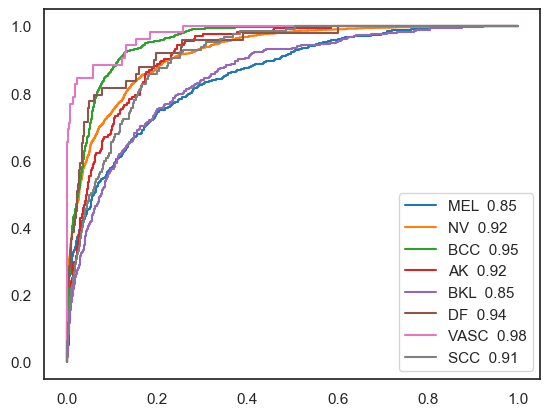

In [58]:
disease_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
num_classes = len(disease_labels)

plt.figure()
sns.set_theme(style="white", palette=None)

for i in range(num_classes):
    true_labels = df['target_'+str(i)]
    pred_labels = df['class_'+str(i)]
    if true_labels.sum() == 0:
        continue
    fpr, tpr, thres = roc_curve(true_labels, pred_labels)
    
    
    plt.plot(fpr,tpr,label = disease_labels[i]+'  {:.2f}'.format(roc_auc_score(true_labels, pred_labels)))
    print('AUROC of {}: \t{:.2f}'.format(disease_labels[i],roc_auc_score(true_labels, pred_labels)))

plt.legend()
plt.show()

In [95]:
def get_boostrap_ci_for_full_experiment(
    targets: np.ndarray,
    predictions: np.ndarray,
    sex: np.ndarray,
    n_bootstrap: int = 2000,
    level: float = 0.95,
):
    """
    Get all CIs for FPR/TPR/Youden/AUC per subgroup for a global threshold with target fpr of 0.2
    """
    n_samples = targets.shape[0]

    all_fpr, all_tpr, all_roc_auc, all_youden = (
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
    )

    for b in tqdm(range(n_bootstrap + 1)):

        # GET BOOTSTRAP SAMPLE
        # At the first iteration, store the sample estimate without resampling.
        idx = (
            resample(np.arange(n_samples), stratify=targets)
            if b > 0
            else np.arange(n_samples)
        )
        
#         print(len(idx))

        sample_target, sample_pred = targets[idx], predictions[idx]
        sample_sex = sex[idx]

        fpr, tpr, thres = roc_curve(sample_target, sample_pred)
        all_roc_auc["all"].append(auc(fpr, tpr))

        # Computing global threshold
        idx_target_fpr_threshold = np.argmin(np.abs(fpr - target_fpr))
        op = thres[idx_target_fpr_threshold]
        all_fpr["all"].append(fpr[idx_target_fpr_threshold])
        all_tpr["all"].append(tpr[idx_target_fpr_threshold])
        all_youden["all"].append(
            (tpr[idx_target_fpr_threshold] - fpr[idx_target_fpr_threshold])
        )

    
        # Getting sex subgroup results
        for s in [male, female]:
            targets_s, preds_s = (
                sample_target[sample_sex == s],
                sample_pred[sample_sex == s],
            )
            all_roc_auc[s].append(roc_auc_score(targets_s, preds_s))
            all_fpr[s].append(1 - recall_score(targets_s, preds_s >= op, pos_label=0))
            all_tpr[s].append(recall_score(targets_s, preds_s >= op, pos_label=1))
            all_youden[s].append(all_tpr[s][-1] - all_fpr[s][-1])

    def _get_pretty_string_from_bootstrap_estimates(boostrap_estimates: np.ndarray):
        alpha = (1 - level) / 2
        return f"{boostrap_estimates[0]: .3f} ({np.quantile(boostrap_estimates[1:], alpha):.3f}-{np.quantile(boostrap_estimates[1:], 1 - alpha):.3f})"

    return {
        "AUC": {
            male: _get_pretty_string_from_bootstrap_estimates(all_roc_auc[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_roc_auc[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_roc_auc["all"]),
        },
        "TPR": {
            male: _get_pretty_string_from_bootstrap_estimates(all_tpr[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_tpr[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_tpr["all"]),
        },
        "FPR": {
            male: _get_pretty_string_from_bootstrap_estimates(all_fpr[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_fpr[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_fpr["all"]),
        },
        "Youden's Index": {
            male: _get_pretty_string_from_bootstrap_estimates(all_youden[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_youden[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_youden["all"]),
        },
    }


In [96]:
target_fpr = 0.2

# PARAMETERS FOR CI
n_bootstrap = 100
ci_level = 0.95

male = "male"
female = "female"

# GET RESULTS
for i in range(num_classes):
    true_labels = df['target_'+str(i)]
    pred_labels = df['class_'+str(i)]
    if true_labels.sum()==0:
        continue
    
    sex = df.sex.values

    results = get_boostrap_ci_for_full_experiment(
            targets=true_labels,
            predictions=pred_labels,
            sex=sex,
            n_bootstrap=n_bootstrap,
        )

    columns_as_in_manuscript = [female, male, "all"]
    res_df = pd.DataFrame.from_dict(results, orient="index")[
            columns_as_in_manuscript
        ]
    print(
            f"\nResults for: {disease_labels[i].upper()} ({ci_level * 100:.0f}%-CI with {n_bootstrap} bootstrap samples)"
        )
    print(tabulate(res_df, headers=res_df.columns))

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 89.45it/s]



Results for: MEL (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.850 (0.835-0.867)  0.858 (0.839-0.873)  0.854 (0.842-0.866)
TPR             0.728 (0.679-0.764)  0.754 (0.704-0.789)  0.742 (0.706-0.768)
FPR             0.193 (0.180-0.203)  0.206 (0.198-0.218)  0.200 (0.199-0.200)
Youden's Index  0.535 (0.485-0.585)  0.548 (0.498-0.583)  0.542 (0.505-0.568)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 84.31it/s]



Results for: NV (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.923 (0.912-0.934)  0.922 (0.911-0.931)  0.922 (0.915-0.929)
TPR             0.873 (0.848-0.897)  0.876 (0.849-0.897)  0.874 (0.851-0.894)
FPR             0.201 (0.181-0.215)  0.199 (0.186-0.217)  0.200 (0.199-0.201)
Youden's Index  0.672 (0.645-0.704)  0.676 (0.643-0.703)  0.674 (0.651-0.694)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 89.18it/s]



Results for: BCC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.959 (0.950-0.966)  0.950 (0.944-0.958)  0.955 (0.949-0.960)
TPR             0.954 (0.928-0.977)  0.958 (0.935-0.977)  0.956 (0.939-0.973)
FPR             0.202 (0.184-0.210)  0.209 (0.191-0.213)  0.206 (0.199-0.200)
Youden's Index  0.752 (0.723-0.784)  0.749 (0.729-0.773)  0.751 (0.739-0.773)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 93.51it/s]



Results for: AK (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.909 (0.881-0.930)  0.925 (0.906-0.943)  0.918 (0.902-0.932)
TPR             0.855 (0.749-0.935)  0.899 (0.841-0.957)  0.880 (0.825-0.931)
FPR             0.199 (0.187-0.210)  0.200 (0.191-0.212)  0.200 (0.200-0.200)
Youden's Index  0.656 (0.546-0.739)  0.699 (0.643-0.757)  0.680 (0.625-0.731)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 90.34it/s]



Results for: BKL (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.856 (0.822-0.881)  0.852 (0.822-0.876)  0.854 (0.835-0.874)
TPR             0.747 (0.671-0.802)  0.753 (0.689-0.821)  0.751 (0.699-0.803)
FPR             0.196 (0.183-0.207)  0.204 (0.194-0.215)  0.200 (0.199-0.201)
Youden's Index  0.551 (0.467-0.606)  0.549 (0.485-0.614)  0.550 (0.498-0.603)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 91.39it/s]



Results for: DF (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.956 (0.925-0.985)  0.917 (0.849-0.966)  0.937 (0.902-0.963)
TPR             0.920 (0.825-1.000)  0.875 (0.693-1.000)  0.898 (0.796-0.980)
FPR             0.202 (0.196-0.219)  0.192 (0.183-0.204)  0.197 (0.199-0.201)
Youden's Index  0.718 (0.624-0.793)  0.683 (0.499-0.812)  0.701 (0.596-0.779)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 96.50it/s]



Results for: VASC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.974 (0.955-0.991)  0.982 (0.960-0.995)  0.977 (0.961-0.990)
TPR             0.931 (0.885-1.000)  1.000 (1.000-1.000)  0.962 (0.942-1.000)
FPR             0.177 (0.181-0.209)  0.190 (0.192-0.217)  0.184 (0.199-0.200)
Youden's Index  0.754 (0.699-0.816)  0.810 (0.783-0.808)  0.777 (0.742-0.800)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 91.12it/s]


Results for: SCC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.910 (0.886-0.932)  0.905 (0.876-0.925)  0.907 (0.889-0.924)
TPR             0.883 (0.818-0.962)  0.836 (0.740-0.910)  0.858 (0.807-0.913)
FPR             0.193 (0.179-0.206)  0.204 (0.194-0.218)  0.199 (0.199-0.200)
Youden's Index  0.690 (0.624-0.770)  0.632 (0.533-0.707)  0.659 (0.607-0.713)
